# Landslide Detection Challenge - Starter Notebook

Welcome to the Landslide Detection Challenge! This notebook will guide you through:
1. Loading and exploring the multi-band dataset provided in `.npy` format.
2. Visualizing the multi-band satellite data and understanding label distribution.
3. Building and evaluating a baseline model to classify landslide and non-landslide images.

Let’s get started with loading and understanding the data!


## Block 1: Import Libraries

In [1]:
# Import necessary libraries
import os
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import lightgbm as lgb
from lightgbm import LGBMClassifier
from optuna.samplers import RandomSampler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import optuna

2025-08-01 16:56:47.652258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754067407.691407      83 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754067407.701686      83 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Block 2: Define Paths and Load CSV Files

In [166]:
# Define paths for the dataset (remember to unzip the dataset first!)
train_csv_path = '/kaggle/input/landslide-detection/Train.csv'  # Path to the training labels CSV file
test_csv_path = '/kaggle/input/landslide-detection/Test.csv'    # Path to the test image IDs CSV file
train_data_path = '/kaggle/input/landslide-detection/train_data/train_data'  # Folder where .npy train files are located
test_data_path = '/kaggle/input/landslide-detection/test_data/test_data'    # Folder where .npy test files are located

# Load Train.csv and inspect the data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
print("Train.csv:")
print(train_df.head())

Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0


In [3]:
train_df.label.value_counts()

label
0    5892
1    1255
Name: count, dtype: int64

### Explanation
- **Define Paths**: Specify paths to `Train.csv`, `Test.csv`, and folders containing `.npy` files for training and testing images.
- **Load Train.csv**: We read the `Train.csv` file, which contains `ID` and `label` columns. The `label` is binary, indicating whether the image contains a landslide (1) or not (0).


## Block 4: Load, Normalize, and Display Sample Multi-band Images

# Ensemble Methods

In [4]:
def load_image(image_id, folder_path):
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r')
    img = img.astype('float32')
    return img

X = np.array([load_image(image_id, train_data_path) for image_id in train_df['ID']])
X_test_arrays = np.array([load_image(image_id, test_data_path) for image_id in test_df['ID']])
y = train_df['label'].values

In [5]:
def extract_features(img):
    # img: (batch, H, W, 12)

    # Bands 1-4: Optical
    red, green, blue, nir = [img[:, :, :, i] for i in range(4)]
    ndvi = (nir - red) / (nir + red + 1e-5)
    ndwi = (green - nir) / (green + nir + 1e-5)

    # Radar Descending
    vv_desc, vh_desc = img[:, :, :, 4], img[:, :, :, 5]
    vv_vh_ratio_desc = (vv_desc + 1e-5) / (vh_desc + 1e-5)

    # Radar Ascending
    vv_asc, vh_asc = img[:, :, :, 8], img[:, :, :, 9]
    vv_vh_ratio_asc = (vv_asc + 1e-5) / (vh_asc + 1e-5)

    # Expand NDVI etc. to (batch, H, W, 1) before concatenation
    ndvi = ndvi[..., np.newaxis]
    ndwi = ndwi[..., np.newaxis]
    vv_vh_ratio_desc = vv_vh_ratio_desc[..., np.newaxis]
    vv_vh_ratio_asc = vv_vh_ratio_asc[..., np.newaxis]

    # Concatenate along channel axis
    features = np.concatenate([img, ndvi, ndwi, vv_vh_ratio_desc, vv_vh_ratio_asc], axis=-1)
    return features

X_features = extract_features(X)
X_test_features = extract_features(X_test_arrays)

In [167]:
from scipy.stats import kurtosis, skew
def means(df, X):
    df1 = df.copy()

    # Bands 1 to 12
    for band in range(12):
        data = X[:, :, :, band]
        df1[f'band{band+1}_mean'] = data.mean(axis=(1, 2))
        df1[f'band{band+1}_std']  = data.std(axis=(1, 2))
        df1[f'band{band+1}_min']  = data.min(axis=(1, 2))
        df1[f'band{band+1}_max']  = data.max(axis=(1, 2))
        df1[f'band{band+1}_kurt'] = kurtosis(data, axis=(1, 2), fisher=True)
        df1[f'band{band+1}_skew'] = skew(data, axis=(1, 2))

    # NDVI and NDWI (bands 13, 14 in X)
    for name, idx in zip(['ndvi', 'ndwi'], [12, 13]):
        data = X[:, :, :, idx]
        df1[f'{name}_mean'] = data.mean(axis=(1, 2))
        df1[f'{name}_std']  = data.std(axis=(1, 2))
        df1[f'{name}_min']  = data.min(axis=(1, 2))
        df1[f'{name}_max']  = data.max(axis=(1, 2))
        df1[f'{name}_kurt'] = kurtosis(data, axis=(1, 2), fisher=True)
        df1[f'{name}_skew'] = skew(data, axis=(1, 2))

    return df1

# Apply to training dataframe
training_df = means(train_df, X_features)
testing_df = means(test_df, X_test_features)

In [168]:
###### from sklearn.feature_selection import SelectFromModel
lgb_model = XGBClassifier(random_state=42)

X_df = training_df.drop(columns=['ID', 'label'])
y_df = training_df['label']

selector = SelectFromModel(lgb_model, threshold='median', prefit=False)
selector.fit(X_df, y_df)
# Get selected features
selected_features = X_df.columns[selector.get_support()]
X_selected = X_df[selected_features]

In [169]:
X_train, X_val, y_train, y_val = train_test_split(X_selected, y_df, stratify=y_df, random_state=42)
xgb =XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [199]:
def cross_validate_model(model, X, y, n_splits=5, random_state=42):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_preds = np.zeros_like(y, dtype=float)
    f1_scores, acc_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        # Fit model
        model.fit(X_train, y_train)
        
        # Predict probabilities or classes
        y_pred_probs = model.predict_proba(X_val)[:,1]
        scores = []
        thresholds = np.linspace(0.2,0.8,26)
        for thresh in thresholds:
            pred = (y_pred_probs > thresh).astype(int)
            scores.append(f1_score(y_val, pred))

        best_threshold = thresholds[np.argmax(scores)]
        y_pred = (y_pred_probs > best_threshold).astype(int)
        f1_scores.append(f1_score(y_val, y_pred))
        
        # Save OOF predictions
        oof_preds[val_idx] = y_pred
        
        # Compute metrics
        f1 = f1_score(y_val, y_pred, average='binary')
        acc = accuracy_score(y_val, y_pred)
        f1_scores.append(f1)
        acc_scores.append(acc)
        
        print(f"Fold {fold+1} F1: {f1:.4f} | Accuracy: {acc:.4f} | Threshold: {best_threshold:.4f}")
    
    print("="*40)
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")

cross_validate_model(xgb, X_selected, y_df)

Fold 1/5
Fold 1 F1: 0.8377 | Accuracy: 0.9434 | Threshold: 0.4160
Fold 2/5
Fold 2 F1: 0.8463 | Accuracy: 0.9462 | Threshold: 0.3440
Fold 3/5
Fold 3 F1: 0.8732 | Accuracy: 0.9559 | Threshold: 0.3680
Fold 4/5
Fold 4 F1: 0.8885 | Accuracy: 0.9594 | Threshold: 0.3200
Fold 5/5
Fold 5 F1: 0.8446 | Accuracy: 0.9454 | Threshold: 0.3440
Mean F1 Score: 0.8581
Mean Accuracy: 0.9501


F1 Score: 0.8367



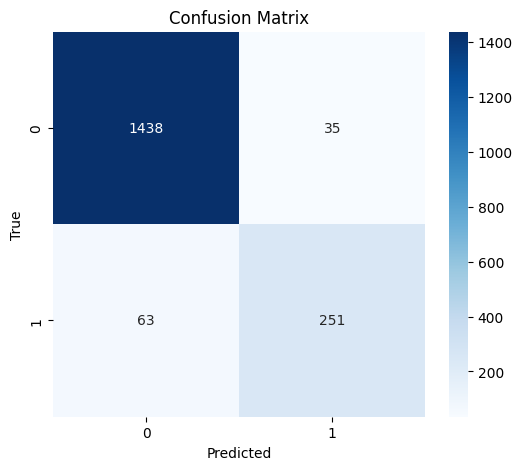

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1473
           1       0.88      0.80      0.84       314

    accuracy                           0.95      1787
   macro avg       0.92      0.89      0.90      1787
weighted avg       0.94      0.95      0.94      1787



In [112]:
def evaluate_model(model, X_test, y_test):

    # Predict probabilities
    y_pred = model.predict(X_test)

    # Compute F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Detailed report
    print(classification_report(y_test, y_pred))


evaluate_model(xgb, X_val, y_val)

In [173]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "random_state": 42,

    }

    f1_scores = []

    model = XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
        )

    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred))

    return np.mean(f1_scores)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(objective, n_trials=50)

print("Best F1:", xgb_study.best_value)
print("Best Params:", xgb_study.best_params)

Best F1: 0.8576214405360134
Best Params: {'max_depth': 8, 'learning_rate': 0.056311061482552126, 'subsample': 0.7343774118814447, 'colsample_bytree': 0.8439736262838902, 'min_child_weight': 4.54993372244021, 'gamma': 3.144985561439423, 'reg_lambda': 0.6311578842742878, 'reg_alpha': 0.0006107164391110727}


In [200]:
best_xgb = XGBClassifier(**xgb_study.best_params)
cross_validate_model(best_xgb, X_selected, y_df)

Fold 1/5
Fold 1 F1: 0.8417 | Accuracy: 0.9469 | Threshold: 0.5360
Fold 2/5
Fold 2 F1: 0.8263 | Accuracy: 0.9392 | Threshold: 0.3440
Fold 3/5
Fold 3 F1: 0.8447 | Accuracy: 0.9475 | Threshold: 0.4160
Fold 4/5
Fold 4 F1: 0.8654 | Accuracy: 0.9510 | Threshold: 0.4160
Fold 5/5
Fold 5 F1: 0.8498 | Accuracy: 0.9468 | Threshold: 0.3920
Mean F1 Score: 0.8456
Mean Accuracy: 0.9463


In [14]:
def threshold_tuning(model, X_test, y_test):
    scores = []
    thresholds = np.linspace(0.1, 1, 10)
    for thresh in thresholds:
        y_pred = model.predict_proba(X_test)[:, 1]
        y_tuned = (y_pred > thresh).astype(int)
        scores.append(f1_score(y_test, y_tuned))

    fig = px.line(x=thresholds, y=scores, title='Threshold Tuning', template='plotly_white')
    fig.update_traces(line=dict(color='red'))
    fig.update_layout(xaxis_title='Thresholds',
                      yaxis_title='F1 Scores',
                      height=500,
                      width=800)
    
    fig.show()

threshold_tuning(best_xgb, X_val, y_val)

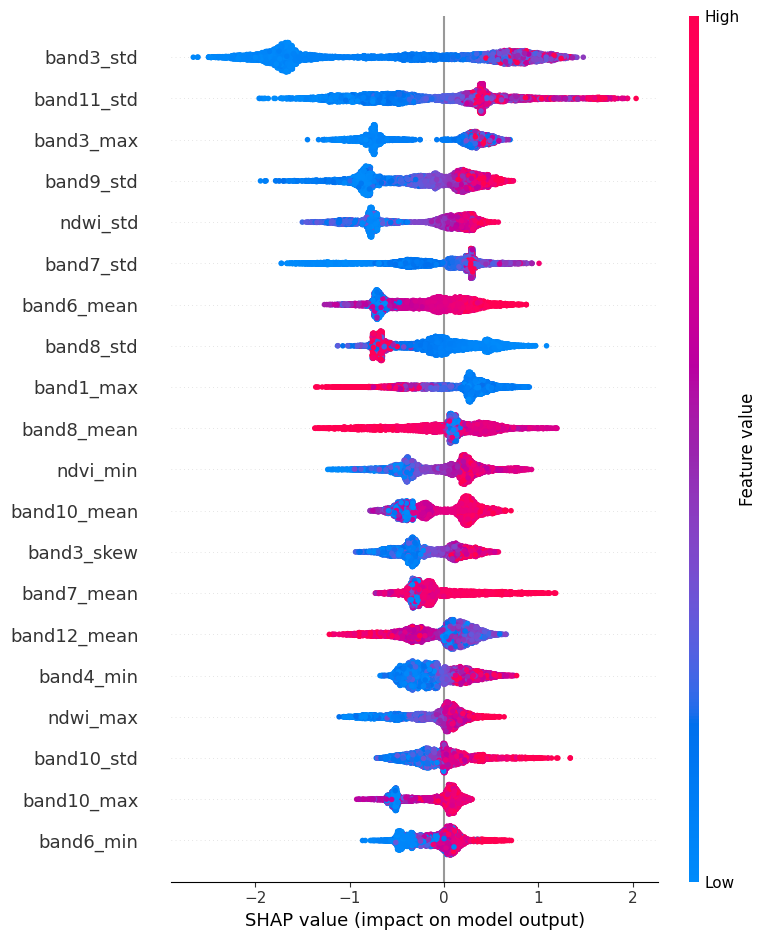

In [114]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

## LGB

In [180]:
# 1️⃣ Train LightGBM
lgb_model = LGBMClassifier(n_estimators=500, max_depth=-1, learning_rate=0.05)
lgb_model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=500)

In [203]:
cross_validate_model(lgb_model, X_selected, y_df)

Fold 1/5
Fold 1 F1: 0.8595 | Accuracy: 0.9524 | Threshold: 0.5360
Fold 2/5
Fold 2 F1: 0.8525 | Accuracy: 0.9497 | Threshold: 0.3920
Fold 3/5
Fold 3 F1: 0.8745 | Accuracy: 0.9566 | Threshold: 0.3680
Fold 4/5
Fold 4 F1: 0.8819 | Accuracy: 0.9580 | Threshold: 0.3200
Fold 5/5
Fold 5 F1: 0.8694 | Accuracy: 0.9552 | Threshold: 0.4400
Mean F1 Score: 0.8675
Mean Accuracy: 0.9544


In [189]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "verbose": -1
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []


    model = LGBMClassifier(**params, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='binary_logloss',
        callbacks=[]
        )

    y_pred = model.predict(X_val)
    
    f1_scores.append(f1_score(y_val, y_pred))

    return np.mean(f1_scores)

    return np.mean(f1_scores)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(objective, n_trials=50)

print("Best F1:", lgbm_study.best_value)
print("Best Params:", lgbm_study.best_params)

Best F1: 0.8666666666666667
Best Params: {'n_estimators': 430, 'learning_rate': 0.07903459079577775, 'max_depth': 13, 'num_leaves': 78, 'subsample': 0.8139946766556813, 'colsample_bytree': 0.9070623220281999, 'min_child_samples': 44}


In [206]:
best_lgbm = LGBMClassifier(**lgbm_study.best_params)
cross_validate_model(best_lgbm, X_selected, y_df)

Fold 1/5
Fold 1 F1: 0.8623 | Accuracy: 0.9524 | Threshold: 0.4400
Fold 2/5
Fold 2 F1: 0.8508 | Accuracy: 0.9483 | Threshold: 0.2000
Fold 3/5
Fold 3 F1: 0.8848 | Accuracy: 0.9608 | Threshold: 0.4400
Fold 4/5
Fold 4 F1: 0.8943 | Accuracy: 0.9636 | Threshold: 0.6560
Fold 5/5
Fold 5 F1: 0.8625 | Accuracy: 0.9538 | Threshold: 0.5840
Mean F1 Score: 0.8709
Mean Accuracy: 0.9558


## Block 9: Make Predictions on the Test Set and Prepare Submission

In [191]:
X_preds = testing_df.drop('ID', axis=1)

## Ensemble Models

In [30]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
stack = StackingClassifier(estimators=[
        ('lgbm', best_lgbm),
        ('xgb', best_xgb)], 
    final_estimator=logreg, cv=5, verbose=1)
stack.fit(X_df, y_df)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished


StackingClassifier(cv=5,
                   estimators=[('lgbm',
                                LGBMClassifier(colsample_bytree=0.6879647131162367,
                                               learning_rate=0.2424251544607824,
                                               max_depth=15,
                                               min_child_samples=13,
                                               n_estimators=694, num_leaves=26,
                                               subsample=0.7115819666303441)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree...
                                              learning_rate=0.18509882516719414,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=4.046055648793488,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(random_state=42),
                   verbose=1)

In [192]:
cross_validate_model(best_lgbm, X_selected, y_df)

Fold 1/5
Fold 1 F1: 0.8612 | Accuracy: 0.9524
Fold 2/5
Fold 2 F1: 0.8476 | Accuracy: 0.9490
Fold 3/5
Fold 3 F1: 0.8802 | Accuracy: 0.9594
Fold 4/5
Fold 4 F1: 0.8898 | Accuracy: 0.9615
Fold 5/5
Fold 5 F1: 0.8619 | Accuracy: 0.9531
Mean F1 Score: 0.8681
Mean Accuracy: 0.9551


In [193]:
def blend_models_f1(model1, model2, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y))  # out-of-fold predictions
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n🔹 Fold {fold}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Clone models for each fold to avoid contamination
        m1 = model1.__class__(**model1.get_params())
        m2 = model2.__class__(**model2.get_params())
        
        # Train both models
        m1.fit(X_train, y_train)
        m2.fit(X_train, y_train)
        
        # Get predictions
        p1 = m1.predict_proba(X_val)[:, 1]
        p2 = m2.predict_proba(X_val)[:, 1]
        
        # Average predictions
        avg_pred = (p1 + p2) / 2
        
        # Threshold at 0.5 for binary classification
        oof_preds[val_idx] = (avg_pred > 0.4).astype(int)
        
        fold_f1 = f1_score(y_val, oof_preds[val_idx])
        print(f"Fold {fold} F1 Score: {fold_f1:.4f}")

    overall_f1 = f1_score(y, oof_preds)
    print(f"\n✅ Overall F1 Score: {overall_f1:.4f}")


blend_models_f1(best_xgb, best_lgbm, X_selected, y_df)


🔹 Fold 1/5
Fold 1 F1 Score: 0.8525

🔹 Fold 2/5
Fold 2 F1 Score: 0.8512

🔹 Fold 3/5
Fold 3 F1 Score: 0.8712

🔹 Fold 4/5
Fold 4 F1 Score: 0.8907

🔹 Fold 5/5
Fold 5 F1 Score: 0.8623

✅ Overall F1 Score: 0.8657


## Single Model

In [226]:
def stratifiedKFold(model):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    test_preds = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y_df)):
        print(f"Fold {fold+1}")
    
        # Use the same DataFrames as in split
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_df.iloc[train_idx], y_df.iloc[val_idx]
    
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
        )
    
        # Validation predictions and F1
        y_pred_val = model.predict(X_val)
        f1 = f1_score(y_val, y_pred_val)
        f1_scores.append(f1)
        print(f"Fold {fold+1} F1: {f1:.4f}")
    
        # Test predictions (probabilities)
        y_pred_test = model.predict_proba(X_preds[X_selected.columns])[:, 1]
        test_preds.append(y_pred_test)
    
    # ✅ Average test predictions from 5 folds
    final_test_preds = np.mean(test_preds, axis=0)
    
    # ✅ Convert to class labels with custom threshold
    final_labels = (final_test_preds >= 0.2).astype(int)
    
    print("CV Mean F1:", np.mean(f1_scores))
    return final_labels

In [227]:
#y_pred = stratifiedKFold(best_xgb)
y_pred = stratifiedKFold(best_lgbm)

Fold 1
Fold 1 F1: 0.8612
Fold 2
Fold 2 F1: 0.8476
Fold 3
Fold 3 F1: 0.8802
Fold 4
Fold 4 F1: 0.8898
Fold 5
Fold 5 F1: 0.8619
CV Mean F1: 0.8681248346400754


In [225]:
def blend_models_kfold(model1, model2, X_train, y_train, X_test, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    test_preds_folds = []
    oof_preds = np.zeros(len(y_train))

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f"\n🔹 Fold {fold}/{n_splits}")

        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # Clone models per fold
        m1 = model1.__class__(**model1.get_params())
        m2 = model2.__class__(**model2.get_params())

        # Train models
        m1.fit(X_tr, y_tr)
        m2.fit(X_tr, y_tr)

        # Predict probabilities
        p1_val = m1.predict_proba(X_val)[:, 1]
        p2_val = m2.predict_proba(X_val)[:, 1]
        val_avg = (p1_val + p2_val) / 2
        oof_preds[val_idx] = val_avg

        # Predict test set probabilities
        p1_test = m1.predict_proba(X_test)[:, 1]
        p2_test = m2.predict_proba(X_test)[:, 1]
        test_avg = (p1_test + p2_test) / 2
        test_preds_folds.append(test_avg)

    # Average predictions across folds
    test_preds_final = np.mean(test_preds_folds, axis=0)

    final_preds_binary = (test_preds_final > 0.3).astype(int)

    return final_preds_binary

y_pred = blend_models_kfold(best_lgbm, best_xgb, X_df, y_df, X_preds[X_df.columns])


🔹 Fold 1/5

🔹 Fold 2/5

🔹 Fold 3/5


KeyboardInterrupt: 

In [228]:
test_ids = test_df['ID'].values
# Predict probabilities and classify as 0 or 1

# Count the number of predictions for each class
unique, counts = np.unique(y_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)

# Prepare submission file
submission_df = pd.DataFrame({
    'ID': test_ids,
    'label': y_pred.flatten()  # Flatten to match submission format
})
submission_df.to_csv('/kaggle/working/Submission_File.csv', index=False)
print("Sample submission file created as 'Submission_File.csv'.")

Prediction counts: {0: 4672, 1: 726}
Sample submission file created as 'Submission_File.csv'.


In [ ]:
from xgboost import plot_importance
plot_importance(best_xgb, importance_type='gain', max_num_features=20)
plt.show()

## Transfer Learning

### Explanation
1. **Count Predictions**:
   - After making predictions on `X_test`, we use `np.unique` with `return_counts=True` to count the occurrences of `0`s and `1`s in `y_test_pred`.
   - We print the counts, which shows the distribution of predicted labels.

2. **Interpretation**:
   - The counts provide insight into whether the model is predicting a balanced number of `0`s and `1`s or if it's skewed towards one class.
   - Please consider that the test set is imbalanced towards the non-landslide class.
   - This check is particularly useful for binary classification problems where class imbalance could impact the model’s evaluation.

3. **Prepare Submission File**:
   - The `Submission_File.csv` file is created in the same way, ready for submission.